# 3장 - 분류

1장에서는 가장 일반적인 지도 학습 작업이 회귀(값 예측)와 분류(클래스 예측)라고 했습니다. 2장에서는 주택 각격을 예측하는 회귀 작업을 살펴보면서 선형 회귀, 결정 트리, 랜덤 포레스트(7장에서 더 자세히 설명합니다) 같은 여러 알고리즘을 보았습니다. 이 장에서는 분류 시스템을 집중적으로 다루겠습니다.

In [1]:
import sys
import sklearn

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 3.1 MNIST

이 장에서는 고등학생과 미국 인구 조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 MNIST 데이터셋을 사용하겠습니다. 각 이미지에는 어떤 숫자를 나타내는지 레이블되어 있습니다. 이 데이터셋은 학습용으로 아주 많이 사용되기 때문에 머신러닝 분야의 'Hello World'라고 불립니다. 새로운 분류 알고리즘이 나올 때마다 MNIST 데이터셋에서 얼마나 잘 작동하는지 봅니다. 머신러닝을 배우는 사람이라면 머지않아 MNIST 데이터셋을 맞닥뜨리게 될 것입니다.

사이킷런에서 제공하는 여러 헬퍼 함수를 사용해 잘 알려진 데이터셋을 내려받을 수 있습니다. MNIST도 그중 하나입니다. 다음은 MNIST 데이터셋을 내려받는 코드입니다.\*

---

\* 기본적으로 사이킷런은 내려받은 데이터셋을 `＄HOME／scikit_learn_data`디렉터리에 캐싱합니다.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있습니다.\*

- 데이터셋을 설명하는 `DESCR` 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 `data` 키
- 레이블 배열을 담은 `target` 키

이 베열들을 살펴보겠습니다.

---

\* 사이킷런

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
28 * 28

784

이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있습니다. 이미지가 28 × 28 픽셀이기 때문이죠. 개개의 특성은 단순히 0(흰색)부터 255(검은색)까지 픽셀 강도를 나타냅니다. 데이터셋에서 이미지 하나를 확인해보겠습니다. 샘플의 특성 벡터를 추출해서 28 × 28 배열로 크기를 바꾸고 맷플롯립의 `imshow()` 함수를 사용해 그리면 됩니다.

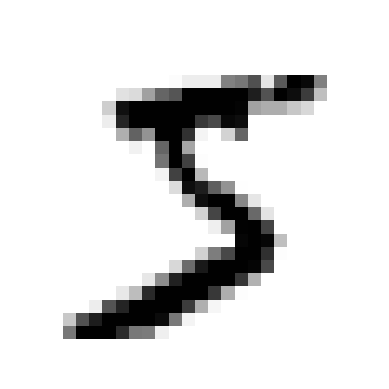

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

이 그림은 숫자 5로 보이는데, 실제 레이블을 확인해보겠습니다.

In [7]:
y[0]

'5'

레이블은 문자열입니다. 대부분 머신러닝 알고리즘은 숫자를 기대하므로 `y`를 정수로 변환하겠습니다.

In [8]:
y = y.astype(np.uint8)

아래 그림에서 MNIST 이미지 샘플을 더 확인해보면 분류 작업이 얼마나 어려운지 느낄 수 있을 것입니다.

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

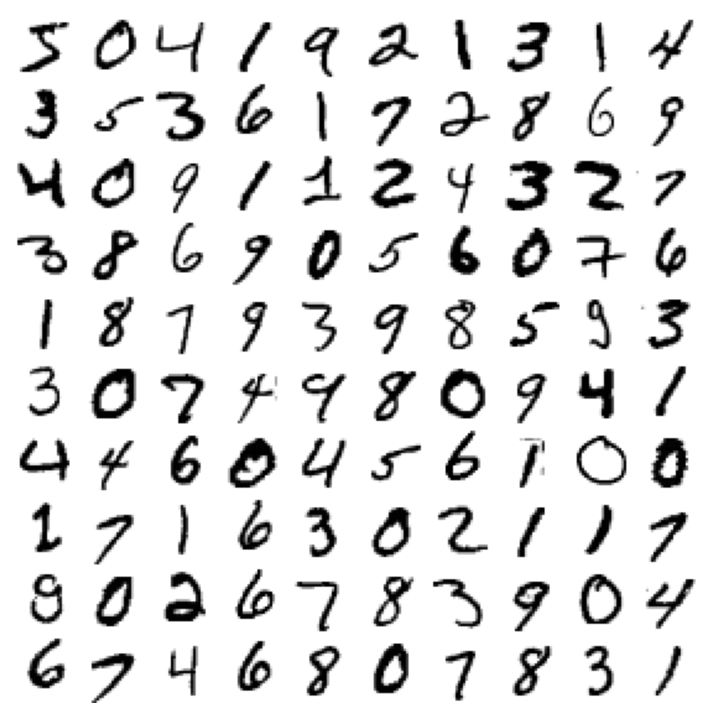

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

하지만 잠깐만요! 데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야합니다. 사실 MNIST 데이터셋은 이미 훈련 세트(앞쪽 60,000개 이미지)와 테스트 세트(뒤쪽 10,000개 이미지)로 나누어놓았습니다.

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듭니다(하나의 폴드하고 특정 숫자가 누락되면 안 됩니다). 더군다나 어떤 학습 알고리즘은 훈련 샘플의 순서에 김감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠집니다. 데이터셋을 섞으면 이런 문제를 방지할 수 있습니다.

---

\* 어떤 경우에는 섞는 것이 좋지 않습니다. 예를 들면 (주식가격이나 날씨 예보 같은) 시계열 데이터를 다룰 때입니다. 다음 장에서 이런 경우를 살펴보겠습니다. SGD가 샘플을 섞어야 하는 대표적인 경우입니다. 사이킷런의 `SGDClassifier`와 `SGDRegressor`는 기본적으로 에포크(max_iter)마다 훈련 데이터를 다시 섞습니다.

## 3.2 이진 분류기 훈련

문제를 단순화해서 하나의 숫자, 예를 들면 수자 5만 식별해보겠습니다. 이 \`5-감지기\`는 \`5\`와 \`5 아님\` 두 개의 클래스를 구분할 수 있는 <span style="color: #008000">이진 분류기</span>$^{binary \ classifier}$의 한 예입니다. 분류 작업을 위해 타깃 벡터를 만들어보겠습니다.

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

좋습니다. 이제 분류 모델을 하나 선택해서 훈련시켜보겠습니다. 사이킷런의 `SGDClassifier`클래스를 사용해 <span style="color: #008000">확률적 경사 하강법</span>$^{Srochastic \ Gradient \ Descent}$(SGD) 분류기로 시작해보는 것도 나쁘지 않습니다. 이 분류기는 매우 큰 데이텃셋을 효율적으로 처리하는 장점을 지니고 있습니다. 나중에 보겠지만 SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문입니다(그래서 GSD가 온라린 학습에 잘 들어맞습니다). `SGDClassifier` 모델을 만들고 전체 훈련 세트를 사용해 훈련시켜보겠습니다.

<span style="color: #FFA500">NOTE_</span> `max_iter`와 `tol` 같은 일부 매개변수는 사이킷런 다음 버전에서 기본값이 바뀝니다. 버전이 업데이트되더라도 결과가 바뀌지 않도록 아예 나중에 바뀔 기본값을 사용해 명시적으로 지정하겠습니다.

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

<span style="color: #FFA500">TIP</span> `SGDClassifier`는 훈련하는 데 무작위성을 사용합니다(그래서 이름에 \`확률적\`이 붙었습니다). 결과를 재현하고 싶다면 `random_state` 매개변수를 지정해야 합니다.

이제 이 모델을 사용해 숫자 5의 이미지를 감지해보겠습니다.

In [15]:
sgd_clf.predict([some_digit])

array([ True])

분류기는 이 이미지가 5를 나타낸다고 추측했습니다(True). 이 경우엔 특별하게 정확히 맞춘것 같습니다! 그럼 모델의 성능을 평가해봅시다.

## 3.3 성능 측정

분류기 평가는 회귀 모델보다 훨씬 어렵기 때문에 이 장에서는 이 주제에 많은 지면을 할애할 것입니다. 사용할 수 있는 성능 지표가 많습니다. 커피 한 잔 더 하면서 여러 가지 새로운 개념과 용어를 배워보죠!

### 3.3.1 교차 검증을 사용한 정확도 측정

2장에서 한 것처럼 교차 검증은 모델을 평가하는 좋은 방법입니다.

**교차 검증 구현**
가끔 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있습니다. 이 때는 교차 검증 기능을 직접 구현하면 됩니다. 다음 코드는 사이킷런의 `cross_val_score()` 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력합니다.

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


`StratifiedKFold`는 (2장에서 설명한 것처럼) 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행합니다. 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듭니다. 그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력합니다.

`cross_val_score()` 함수로 폴드가 3개인 k-갭 교차 검증을 사용해 `SGDClassifier` 모델을 평가해보겠습니다. k-겹 교차 검증은 훈련 세트를 k개(여기서는 3개)의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다는 것을 기억하세요(2장 참조).

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

와우! 모든 교차 검증 폴드에 대해 <span style="color: #008000">정확도</span>$^{accuracy}$(정확한 예측의 비율)가 95％ 이상입니다. 아주 놀랍지 않은가요? 너무 흥분하지 말고 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보겠습니다.

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

모델의 정확도를 추측할 수 있나요? 한번 확인해보죠.

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

<span style="color: #FFA500">NOTE_</span> 노트: 이 출력(그리고 이 노트북과 다른 노트북의 출력)이 책의 내용과 조금 다를 수 있습니다. 걱정할 필요 없습니다. 괜찮습니다! 달라지는 이유가 몇가지 있습니다.

- 첫째, 사이킷런과 다른 라이브러리들이 발전하면서 알고리즘이 조금씩 변경되기 때문에 얻어지는 결괏값이 바뀔 수 있습니다. 최신 사이킷런 버전을 사용한다면(일반적으로 권장됩니다) 책이나 이 노트북을 만들 때 사용한 버전과 다를 것이므로 차이가 납니다. 노트북은 최신으로 업데이트하려고 노력하지만 책의 내용은 그렇게 할 수 없습니다.
- 둘째, 많은 훈련 알고리즘은 확률적입니다. 즉 무작위성에 의존합니다. 이론적으로 의사 난수를 생성하도록 난순 생성기에 시드 값을 지정하여 일관된 결과를 얻을 수 있습니다(random_state=42나 np.random.seed(42)를 종종 보게 되는 이유입니다). 하지만 여기에서 언급한 다른 요인으로 인해 충분하지 않을 때가 있습니다.
- 셋째, 훈련 알고리즘이 여러 스레드(C로 구현된 알고리즘)나 여러 프로세스(예를 들어 n_jobs 매개변수를 사용할 때)로 실행되면 연산이 실행되는 정확한 순서가 항상 보장되지 않습니다. 따라서 결괏값이 조금 다를 수 있습니다.
마지막으로, 여러 세션에 결쳐 순서가 보장되지 않는 파이썬 딕셔너리(dict)이나 셋(set) 같은 것은 완벽한 재현성이 불가능합니다. 또한 디렉토리 안에 있는 파일의 순서도 보장되지 않습니다.

맞습니다. 정확도가 90％ 이상으로 나왔네요! 이미지의 10％ 정도만 숫자 5이기 때문에 무조건 \'5 아님\'으로 예측하면 정확히 맞출 확률이 90％입니다. 노스트라다무스 못지않네요.

이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줍니다. 특히 <span style="color: #008000">불균형한 데이터셋</span>을 다룰 때(즉, 어떤 클래스가 다른 것보다 월등히 많은 경우) 더욱 그렇습니다.

### 3.2.2 오차 행렬

분류기의 성능을 평가하는 더 좋은 방법은 <span style="color: #008000">오차 행렬</span>$^{confusion \ matrix}$을 조사하는 것입니다. 기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것입니다. 예를 들어 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면됩니다.

오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 합니다. 테스트 세트로 예측을 만들 수 있지만 여기서 사용하면 안 됩니다(테스트 세트는 분류기가 출시 준비를 마치고 나서 프로젝트의 맨 마지막에 사용된다는 것을 기억하세요). 대신 `cross_val_predict()`함수를 사용할 수 있습니다.

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

`cross_val_score()` 함수처럼 `cross_val_predict()` 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환합니다. 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됩니다(여기서 깨끗하다는 뜻은 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 의미입니다).

이제 `confusion_matrix()` 함수를 사용해 오차 행렬을 만들 준비가 되었습니다. 타깃 클래스 `(y_train_5)`와 예측 클래스`(y_train_pred)`를 넣고 호출하면 됩니다.

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

오차 행렬의 행은 <span style="color: #008000">실제 클래스</span>를 나타내고 열은 <span style="color: #008000">예측한 클래스</span>를 나타냅니다. 이 행렬의 첫 번째 행은 \'5 아님\' 이미지(<span style="color: #008000">음성 클래스</span>$^{negative \ class}$)에 대한 것으로, 53,057개를 \'5 아님\'으로 정확하게 분류했고(<span style="color: #008000">진짜 으성</span>$^{true \ negative}$이라고 합니다) 나머지 1,522개는 \'5\'라고 잘못 분류했습니다(<span style="color: #008000">거짓 양성</span>$^{false \ positive}$). 두 번째 행은 \'5\' 이미지(<span style="color: #008000">양성 클래스</span>$^{positive \ class}$)에 대한 것으로, 1,325개를 \'5 아님\'으로 잘못 분류했고(<span style="color: #008000">거짓 음성</span>$^{false \ negative}$) 나머지 4,096개를 정확히 \'5\'라고 분류했습니다(<span style="color: #008000">진짜 양성</span>$^{true \ positive}$). 완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주대각선(왼쪽 위에서 오른쪽 아래로)만 0이 아닌 값이 됩니다.

In [22]:
y_train_perfect_predictions = y_train_5  # 완변한척 하자
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

오차 행렬이 많은 정보를 제공해주지만 가끔 더 요약된 지표가 필요할 때도 있습니다. 살펴볼만한 것 하나는 양성 예측의 정확도입니다. 이를 분류기의 <span style="color: #008000">정밀도</span>$^{precision}$라고 합니다.

$$ 정밀도 = \frac{TP}{TP ＋ FP} $$

TP는 진짜 양성의 수이고, FP는 거짓 양성의 수입니다.

확실한 양성 샘플 하나만 예측하면 간단히 완벽한 정밀도를 얻을 수 있지만(정밀도 = 1／1 = 100％), 이는 분류기가 다른 모든 양성 샘플을 무시하기 때문에 그리 유용하지 않습니다. 정밀도는 <span style="color: #008000">재현율</span>$^{recall}$이라는 또 다른 지표와 같이 사용하는 것이 일반적입니다. 재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로, <span style="color: #008000">민감도</span>$^{sensitivity}$ 또는 <span style="color: #008000">진짜 양성 비율</span>$^{true \ positive \ rate}$(TPR)이라고도 합니다.

$$ 재현율 = \frac{TP}{TP ＋ FN} $$

FN은 거짓 음성의 수입니다.

### 3.3.3 정밀도와 재현율

사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공합니다.

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [24]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [25]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [26]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

이제 \'5-감지기\'가 정확도에서 봤을 때만큼 멋져 보이지는 않네요. 5로 판별된 이미지 중 72.9％만 정확합니다. 더군다나 전체 숫자 5에서 75.6％만 감지했습니다.

정밀도와 재현율을 <span style="color: #008000">F₁ 점수</span>$^{F_1 \ score}$라고 하는 하나의 숫자로 만들면 편리할 때가 많습니다. 특이 두 분류기를 비교할 때 그렇습니다. $F_1$ 점수는 정밀도와 재현율의 <span style="color: #008000">조화 평균</span>$^{harmonic \ mean}$입니다.\*

$$ F_1 = \frac{2}{\frac{1}{정밀도} + \frac{1}{재현율}} = 2 × \frac{정밀도 × 재현율}{정밀도 ＋ 재현율} = \frac{TP}{TP ＋ \frac{FN ＋ FP}{2}} $$

$F_1$ 점수를 계산하려면 `f1_score()` 함수를 호출하면 됩니다.

---

\* $F$ 점수의 일반화된 조화 평균 식은 다음과 같습니다.
$$ F = \frac{1}{\frac{\alpha}{정밀도} ＋ \frac{1 － \alpha}{재현율}} = (\beta^2 ＋ 1) × \frac{정밀도 × 재현율}{\beta^2 × 정밀도 ＋ 재현율} \ \ \ \ \ \ \ \ \ , \beta^2 ＝ \frac{1－\alpha}{\alpha}$$
$\beta$가 1보다 크면 재현율이 강조되고 1보다 작으면 정밀도가 강조됩니다. $\beta$가 1일 때의 점수를 $F_1$ 점수라고 합니다.

In [27]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [28]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

정밀도와 재현율이 비슷한 분류기에서는 $F_1$ 점수가 높습니다. 하지만 이게 항상 바람직한 것은 아닙니다. 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있습니다. 예를 들어 어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정해보겠습니다. 재현율은 높으나 정말 나쁜 동영상이 몇 개 노출되는 것보다 좋은 동영상이 많이 제외되더라도(낮은 재현율) 안전한 것들만 노출시키는(높은 정밀도) 분류기를 선호할 것입니다(이런 경우에는 분류기의 동영상 선택 결과를 확인하기 위해 사람이 참여하는 분석 파이프라인을 추가할지도 모릅니다). 다른 예로, 감시 카메라를 통해 좀도둑을 잡아내는 분류기를 훈련시킨다고 가정해보겠습니다. 분류기의 재현율이 99％라면 정확도가 30％만 되더라고 괜찮을지 모릅니다(아마도 경비원이 잘못된 호출을 종종 받게 되겠지만, 거의 모든 좀도둑을 잡을 것입니다).

안됐지만 이 둘을 모두 얻을 수는 없습니다. 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지입니다. 이를 <span style="color: #008000">정밀도／재현율 트레이드오프</span>라고 합니다.

### 3.3.4 정밀도／재현율 트레이드오프

`SGDClassifier`가 분류를 어떻게 결정하는지 살펴보며 이 트레이드오프를 이해해보겠습니다. 이 분류기는 <span style="color: #008000">결정 함수</span>$^{decision \ function}$를 사용하여 각 샘플의 점수를 계산합니다. 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당합니다.

$$ 8 \ 7 \ 3\ 9 \downarrow 5 \ 2 \ 5 \downarrow 5 \ 6 \downarrow 5 \ 5 \ 5 $$

위 숫자에서 가장 낮은 점수부터 가장 높은 점수까지 몇 개의 숫자를 나열했습니다. <span style="color: #008000">결정 임곗값</span>$^{decision \ threshold}$이 가운데(두 개의 숫자 5 사이) 화살표라고 가정해보겠습니다. 임곗값은 오른쪽에 4개의 진짜 양성(실제 숫자 5)과 하나의 거짓 양성(실제 숫자 6)이 있습니다. 그렇기 때문에 이 임곗값에서 정밀도는 80％(5개 중 4개)입니다. 하지만 실제 숫자 5는 6개고 분류기는 4개만 감지했으므로 재현율은 67％(6개 중 4개)입니다. 이번에 임곗값을 높이면(임곗값을 오른쪽 화살표로 옮기면) 거짓 양성(숫자 6)이 진짜 음성이 되어 정밀도가 높아집니다(이 경우에 100％가 됩니다). 하지만 진짜 양성 하나가 거짓 음성이 되었으므로 재현율이 50％로 줄어듭니다. 반대로 임곗값을 내리면 재현율이 높아지고 정밀도가 줄어듭니다.

사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있습니다. 분류기의 `predict()` 메서드 대신 `decision_function()` 메서드를 호출하면 각 샘플의 점수를 얻을 수 있습니다. 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있습니다.

In [29]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [30]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [31]:
y_some_digit_pred

array([ True])

`SDGClassifier`의 임곗값이 0이므로 위 코드는 `predict()` 메서드와 같은 결과(즉, True)를 반환합니다.\* 임곗값을 높여보겠습니다.

---

\* 사실 `predict()` 메서드도 `decision_function()` 함수를 사용하여 0보다 큰 경우를 양성으로 예측합니다.

In [32]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

이 결과는 임곗값을 높이면 재현율이 줄어든다는 것을 보여줍니다. 이미지가 실제로 숫자 5이고 임곗값이 0일 때는 분류기가 이를 감지했지만, 임곗값을 8,000으로 높이면 이를 놓치게 됩니다.

그렇다면 적절한 임곗값을 어떻게 정할 수 있을까요? 이를 위해서는 먼저 `cross_val_predict()` 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 합니다. 하지만 이번에는 예측 결과가 아니라 결정 점수를 반환받도록 지정해야 합니다.

In [33]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

이 점수로 `precision_recall_curve()` 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있습니다. \*

---

\* 사이킷런 0.19.0 버전에서 `cross_val_predict(..., method="decision_function")`가 이전 분류일 때 1차원 배열이 아니고 2차원 배열을 반환하는 버그가 있습니다. 0.19.1 버전으로 업그레이드하거나 `y_scores[:, 1]`처럼 두 번째 열만 사용해야 합니다.

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

이제 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율을 그릴 수 있습니다.

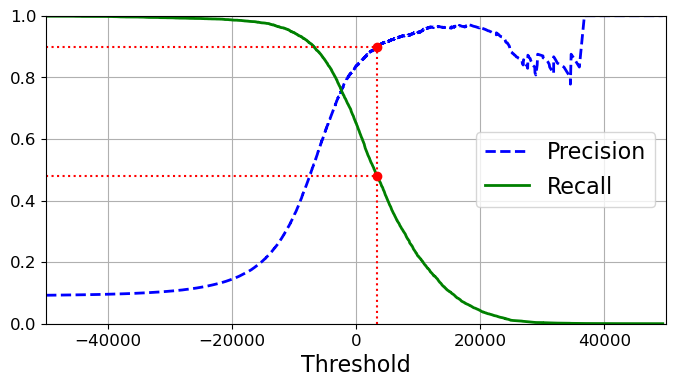

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

<span style="color: #008000">NOTE_</span> 위 그림에서 정밀도 곡선이 재현율 곡선보다 왜 더 울퉁불퉁한지 의아할 수 있습니다. 이는 임곗값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문입니다(일반적으로는 높아져야 합니다). 그 이유를 이해하기 위해 결정 임곗값의 부분을 다시 살펴보겠습니다. 가운데 임곗값에서 오른쪽으로 숫자 하나만큼 이동하면 어떻게 될까요? 정밀도는 4／5(80％)에서 3／4(75％)로 줄어듭니다. 반면 재현율은 임곗값이 올라감에 따라 줄어들 수밖에 없어 위 그림에서처럼 부드러운 곡선이 됩니다.

좋은 정밀도／재현율 트레이드오프를 선택하는 다른 방법은 위 그림처럼 재현율에 대한 정밀도 곡선을 그리는 것입니다(표시된 임곗값은 앞에서와 동일합니다).\*

---

\* `average_precision_score()` 함수를 사용하면 정밀도／재현율 곡선의 아래 면적을 계산할 수 있어서 서로 다른 두 모델을 비교하는 데 도움이 됩니다. 사이킷런 0.22 버전에서도 정밀도／재현율 곡선을 그려주는 `plot_precision_recall_curve()` 함수가 추가되었습니다.

In [36]:
(y_train_pred == (y_scores > 0)).all()

True

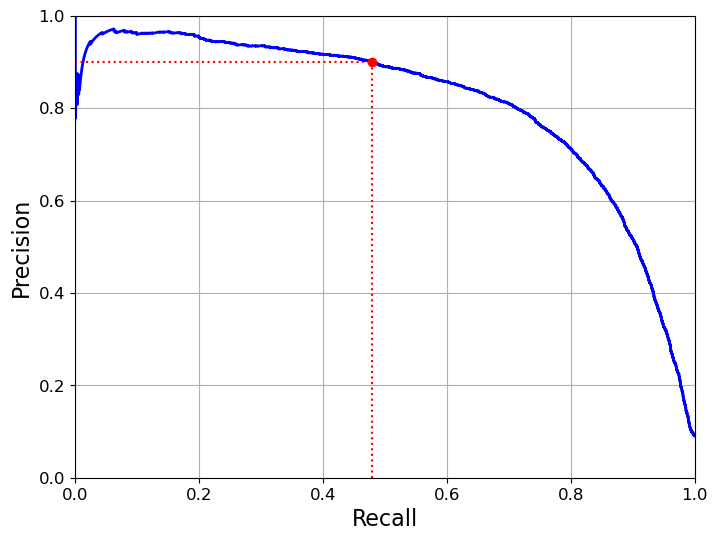

In [37]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

재현율 80％ 근처에서 정밀도가 급격하게 줄어들기 시작합니다. 이 하강점 직전을 정밀도／재현율 트레이드오프로 선택하는 것이 좋습니다. 예를 들면 재현율이 60％ 정도인 지점입니다. 물론 이런 선택은 프로젝트에 따라 달라집니다.

정밀도 90％를 달성하는 것이 목표라고 가정해봅시다. 이전 그림의 그래프에서 임곗값이 약 8,000 정도라는 것을 알 수 있습니다. 조금 더 정확하게 최소한 90％ 정밀도가 되는 가장 낮은 임곗값을 찾을 수 있습니다(`np.argmx()`는 최댓값의 첫 번째 인덱스를 반환합니다. 여기에서는 첫 번째 `True` 값을 의미합니다).

In [38]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [39]:
threshold_90_precision

3370.0194991439557

(훈련 세트에 대한) 예측을 만들려면 분류기의 `predict()` 메서드를 호출하는 대신 다음 코드를 실행합니다.

In [40]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

이 예측에 대한 정밀도와 재현율을 확인해봅시다.

In [41]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [42]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

좋네요. 정밀도 90％를 달성한 분류기를 만들었습니다! 여기서 볼 수 있듯이 어떤 가상의 정밀도에 대해서도 분류기를 손쉽게 만들 수 있습니다. 충분히 큰 임곗값을 지정하면 끝입니다. 흠, 잠깐만요. 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않습니다!

<span style="color: #FFA500">TIP</span> 누군가가 \`99％ 정밀도를 달성하자\`라고 말하면 반드시 \`재현율 얼마에서?\`라고 물어봐야 합니다.

### 3.3.5 ROC 곡선

<span style="color: #008000">수신기 조작 특성</span>$^{receiver \ operating \ characteristic}$(ROC) 곡선도 이진 분류에서 널리 사용하는 도구입니다. 정밀도／재현율 곡선과 매우 비슷하지만, ROC 곡선은 정밀도에 대한 재현율 곡선이 아니고 <span style="color: #008000">거짓 양성 비율</span>$^{false \ positive \ rate}$(FPR)에 대한 <span style="color: #008000">진짜 양성 비율</span>$^{true \ positive \ rate}$(TPR, 재현율의 다른 이름)의 곡선입니다. 양성으로 잘못 분류된 음성 샘플의 비율이 FPR입니다. 이는 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 <span style="color: #008000">진짜 음성 비율</span>$^{true \ negative \ rate}$(TNR)을 뺀 값입니다.\* TNR을 <span style="color: #008000">특이도</span>$^{specificity}$라고도 합니다. 그러므로 ROC 곡선은 <span style="color: #008000">민감도</span>(재현율)에 대한 <span style="color: #008000">1-특이도</span> 그래프입니다.

ROC 곡선을 그리려면 먼저 `roc_curve()` 함수를 사용해 여러 임곗값에서 TPR과 FPR을 계산해야 합니다.

---

\* FPR과 TNR 사이의 관계는 다음과 같습니다.
$$ FPR = \frac{FP}{FP ＋ TN} = \frac{FP ＋ TN － TN}{FP ＋ TN} = 1 － \frac{TN}{FP ＋ TN} = 1 － TNR $$

In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그러면 맷플롯립을 사용해 TPR에 대한 FPR 곡선을 나타낼 수 있습니다. 다음 코드는 그래프를 그립니다.\*

---

\* 사이킷런 0.22 버전에서 ROC 곡선을 그려주는 `plot_roc_curve()` 함수가 추가되었습니다.

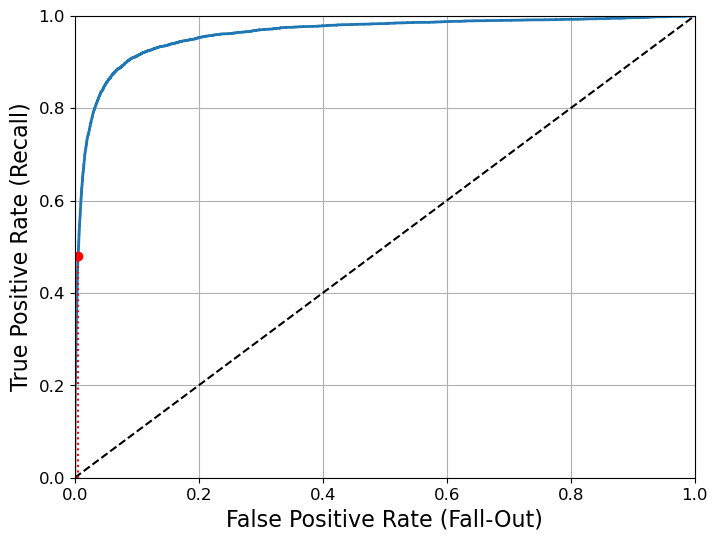

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

여기에서도 트레이드오프가 있습니다. 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어납니다. 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻합니다. 좋은 분류기는 이 점선에서 최대한 멀리 떠러여 있어야 합니다(왼쪽 위 모서리).

<span style="color: #008000">곡선 아래 면적</span>$^{area \ under \ the \ curve}$(AUC)을 측정하면 분류기들을 비교할 수 있습니다. 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5입니다.\* 사이킷런은 ROC의 AUC를 계산하는 함수를 제공합니다.

In [45]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<span style="color: #FFA500">TIP</span> ROC 곡선이 정밀도／재현율(PR) 곡선과 비슷해서 어떤 것을 사용해야 할지 궁금할 수 있습니다. 일반적인 법칙은 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용하고 그렇지 않으면 ROC 곡선을 사용합니다. 예를 들어 조금 전의 ROC 곡선(그리고 ROC의 AUC 점수)을 보면 매우 좋은 분류기라고 생각할 수 있습니다. 하지만 이는 음성(5 아님)에 비해 양성(5)이 크게 적기 때문입니다. 이와는 다르게 PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는지(오른쪽 위 모서리에 가까워질 수 있는지) 잘 보여줍니다.

`RandomForestClassifier`를 훈련시켜 `SGDClassifier`의 ROC 곡선과 ROC AUC 점수를 비교해보겠습니다. 먼저 훈련 세트의 샘플에 대한 점수를 얻어야 합니다. 하지만 작동 방식의 차이 때문에(7장 참조) `RandomForestClassifier`에는 `decision_function()` 메서드가 없습니다. 대신 `predict_proba()` 메서드가 있습니다. 사이킷런 분류기는 일반적으로 이 두 메서드 중 하나 또는 둘 모두를 가지고 있습니다. `predict_proba()` 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환합니다(예를 들어 어떤 이미지가 5일 확률 70％).

In [46]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

`roc_curve()` 함수는 레이블과 점수를 기대합니다. 하지만 점수 대신에 클래스 확률을 전달할 수 있습니다. 양성 클래스 확률을 점수로 사용해보겠습니다.

In [47]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

이제 ROC 곡선을 그릴 준비가 되었습니다. 비교를 위해 첫 번째 ROC 곡선도 함께 그리겠습니다.

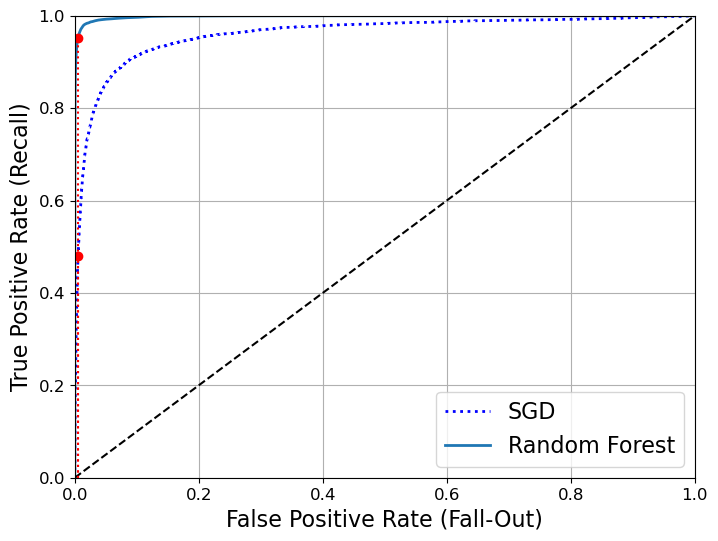

In [48]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

위에서 볼 수 있듯이 `RandomForestClassifier`의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 `SGDClassifier`보다 훨씬 좋아 보입니다. 당연하게 ROC AUC 점수도 훨씬 높습니다.

In [49]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [50]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [51]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

정밀도와 재현율 점수를 계산하면 99.0％ 정밀도와 86.6％ 재현율이 나옵니다. 나쁘지 않군요!

이제 이진 분류기를 훈련시키는 방법과 작업에 맞는 적절한 지표 선택, 교차 검증을 사용한 평가, 요구 사항에 맞는 정밀도／재현율 트레이드오프 선택, ROC 곡선과 ROC AUC 점수를 사용한 여러 모델의 비교에 대해 알게 되었을 것입니다. 다음에는 숫자 5 이상을 감지해보겠습니다.

## 3.4 다중 분류

이진 분류가 두 개의 클래스를 구별하는 반면 <span style="color: #008000">다중 분류기</span>$^{multiclass \ classifier}$(또는 <span style="color: #008000">다항 분류기</span>$^{multinomial \ classifier}$)는 둘 이상의 클래스를 구별할 수 있습니다.

(SGD, 분류기, 랜덤 포레스트 분류기, 나이브 베이즈$^{naive \ Bayes}$ 분류기 같은) 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면, (로지스틱 회귀나 서포트 벡터 머신 분류기 같은) 다른 알고리즘은 이진 분류만 가능합니다. 하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많습니다.

예를 들어 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개(0에서 부터 9까지)를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있습니다. 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 됩니다. 이를 <span style="color: #008000">OvR</span>$^{noe-versus-the-rest}$ 전략이라고 합니다(또는 <span style="color: #008000">OvA</span>$^{one-versus-all}$라고도 부릅니다).

또 다른 전략은 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것입니다. 이를 <span style="color: #008000">OvO</span>$^{one-versus-one}$ 전략이라고 합니다. 클래스가 $N$개라면 분류기는 $N × (N － 1) ／ 2$개가 필요합니다.\* `MNIST` 문제에서는 45개의 분류기를 훈련시켜야 한다는 뜻입니다! 이미지 하나를 분류하려면 45개 분류기 모두를 통과시켜서 가장 많이 양성으로 분류된 클래스를 선택합니다. OvO 전략의 주요 장접은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것입니다.

(서포트 벡터 머신 같은) 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호합니다. 하지만 대부분의 이진 분류 알고리즘에서는 OvR을 선호합니다.

다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행합니다. `sklearn.svm.SVC` 클래스를 사용해 서포트 벡터 머신 분류기를 테스트해보죠.\**

---

\* $n$개의 원소에서 $k$개를 뽑을 수 있는 조합의 수인 이항 계수의 공식은 다음과 같습니다.
$$ \left( \begin{array}{cc} n \\ k \end{array} \right) = \frac{n！}{k！(n－k)！}$$
$N$개의 클래스에서 2개씩 뽑는 조합의 수는 다음과 같습니다.
$$ \left( \begin{array}{cc} N \\ K \end{array} \right) = \frac{N！}{2！(n－2)！} = \frac{N ×(N － 1)}{2}$$

\** liblivear 라이브러리를 사용하는 LinearSVC는 기본적으로 OvR 전략을 사용합니다. SVC 클래스가 사용하는 libsvm 라이브러리는 OvO 전략을 사용합니다.

In [52]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

간단하네요! 이 코드는 5를 구별한 타깃 클래스(`y_train_5`) 대신 0에서 9까지의 원래 타깃 클래스(`y_train`)를 사용해 SVC를 훈련시킵니다. 그런 다음 예측 하나를 만듭니다(정확히 맞추었네요). 내부에서는 사이킷런이 OvO 전략을 사용해 45개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택합니다.

정말 그런지 확인해봅시다. `decision_function()` 메서드를 호출하면 (1개가 아니라) 샘플당 10개의 점수를 반환합니다. 이 점수는 클래스마다 하나씩입니다.

In [53]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

가장 높은 점수가 클래스 5에 해당하는 값입니다.

In [54]:
np.argmax(some_digit_scores)

5

In [55]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [56]:
svm_clf.classes_[5]

5

<span style="color: #FFA500">CAUTION_</span> 분류기가 훈련될 때 `classes_` 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장합니다. 위 예제에서는 `classes_` 배열에 있는 각 클래스의 인덱스가 클래스 값 자체와 같습니다(즉, 인덱스 5에 해당하는 클래스의 값은 5입니다). 하지만 일반적으로 이런 경우는 드뭅니다.

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 `OneVsOneClassifier`나 `OneVsRestClassifier`를 사용합니다. 간단하게 이진 분류기 인스턴스를 만들어 객체를 생성할 때 전달하면 됩니다(심지어 이진 분류기일 필요도 없습니다). 예를 들어 다음 코드는 SVC 기반으로 OvR 전략을 사용하는 다중 분류기를 만듭니다.

In [57]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [58]:
len(ovr_clf.estimators_)

10

`SGDClassifier`(또는 `RandomForestClassifier`)를 훈련시키는 것도 간단합니다.

In [59]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

이 경우 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요가 없습니다. `decision_function()` 메서드는 클래스마다 하나의 값을 반환합니다. SGD 분류기가 클래스마다 부여한 점수를 확인해보겠습니다.

In [60]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

이 결과에서 분류기가 예측 결과에 강한 확신을 보이고 있음을 알 수 있습니다. 대부분의 점수가 큰 음수입니다. 반면 클래스 5의 점수는 2412.5입니다. 이 모델은 573.5의 점수를 얻은 클래스 3을 조금 의심하고 있습니다. 이제 물론 분류기를 평가해보고 싶을 것입니다. 분류기 평가에는 일반적으로 교차 검증을 사용합니다. `cross_val_score()` 함수를 사용해 `SGDClassifier`의 정확도를 평가해보겠습니다.

**경고**: 사용하는 하드웨어에 따라 다음 두 셀을 실행하는데 30분 또는 그 이상 걸릴 수 있습니다.

In [61]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

모든 테스트 폴드에서 84％ 이상을 얻었습니다. 랜덤 분류기를 사용했다면 10％ 정확도를 얻었을 것이므로 이 점수가 아주 나쁘지는 않지만 성능을 더 높일 여지가 있습니다. 예를 들어 간단하게 입력의 스케일을 조정하면 (2장에서처럼) 정확도를 89％ 이상으로 높일 수 있습니다.

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

실제 프로젝트라면 머신러닝 프로젝트 체크리스트(부록 B)의 단계를 따를 것입니다. 데이터 준비 단계에서 가능한 선택 사항을 탐색하고, 여러 모델을 시도하고, 가장 좋은 몇 개를 골라 `GridSearchCV`를 사용해 하이퍼파라미터를 세밀하게 튜닝하고, 앞 장에서 한 것처럼 가능한 한 자동화합니다. 이 절에서는 가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법을 찾아보겠습니다. 한 가지 방법은 만들어진 에러의 종류를 분석하는 것입니다. 먼저 오차 행렬을 살펴볼 수 있습니다. `cross_val_predict()` 함수를 사용해 예측을 만들고 이전처럼 `confusion_matrix()` 함수를 호출합니다.

In [63]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

많은 숫자가 출력됩니다. 오차 행렬을 맷플롯립의 `matshow()` 함수를 사용해 이미지로 표현하면 보기에 편리할 때가 많습니다.\*

---

\* 사이킷런 0.22 버전부터는 `sklearn.metrics.plot_confusion_matrix()` 함수를 사용할 수 있습니다.

In [64]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

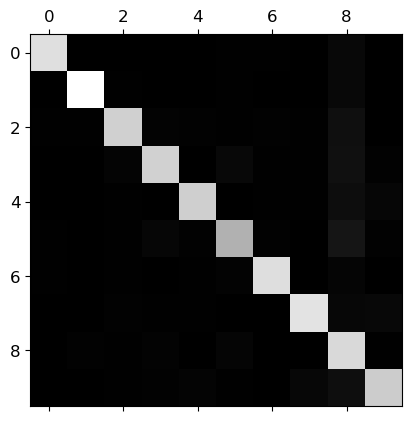

In [65]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보입니다. 숫자 5는 다른 숫자보다 조금 더 어두워 보입니다.\* 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻입니다. 사실 두 경우에 대해 모두 확인해봐야 합니다.

그래프의 에러 부분에 초점을 맞춰보겠습니다. 먼저 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 (에러의 절대 개수가 아니라) 에러 비율을 비교합니다(개수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보입니다\*\*).

---

\* 배열에서 가장 큰 값은 흰색으로, 가장 작은 값은 검은색으로 규정화되어 그려집니다.  
\** `MNIST`는 클래스별 이미지 개수가 동일하지 않습니다.

In [66]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 그립시다.

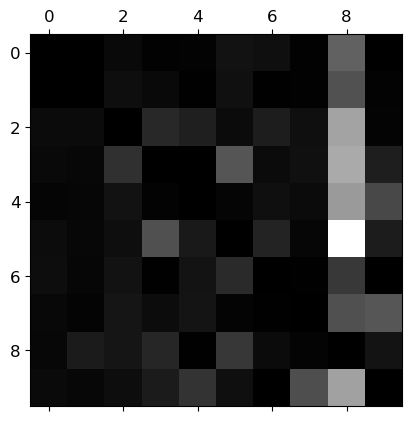

In [67]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

여기서 분류기가 만든 에러를 확실히 볼 수 있습니다. 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다는 사실을 기억하세요. 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시합니다. 하지만 클래스 8의 행은 그리 나쁘지 않습니다. 이는 실제 8이 적절히 8로 분류되었다는 것을 말해줍니다. 여기서 볼 수 있듯이 오차 행렬은 반드시 대칭인 것은 아닙니다. 3과 5가 (서로) 많이 혼동되고 있는 것도 볼 수 있습니다.

오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있습니다. 이 그래프를 살펴보면 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있습니다. 예를 들어 8처럼 보이는 (하지만 실제 8은 아닌) 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있습니다. 또는 분류기에 도움 될 만한 특성을 더 찾아볼 수 있습니다. 예를 들어 동심원의 수를 세는 알고리즘 같은 것입니다(즉, 8은 2개, 6은 1개, 5는 0개입니다). 또는 동심원 같은 어떤 패턴이 드러나도록 (Scikit-Image, Pillow, OpenCV 등을 사용해서) 이미지를 전처리해볼 수 있습니다.

개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대해 통찰을 얻을 수 있지만, 더 어렵고 시간이 오래 걸립니다. 예를 들어 3와 4의 샘플을 그려보겠습니다(`plot_digits()`는 단순히 맷플롯립의 `imshow()` 함수를 사용하는 함수입니다. 자세한 내용은 깃허브의 주피터 노트북을 참고하세요).

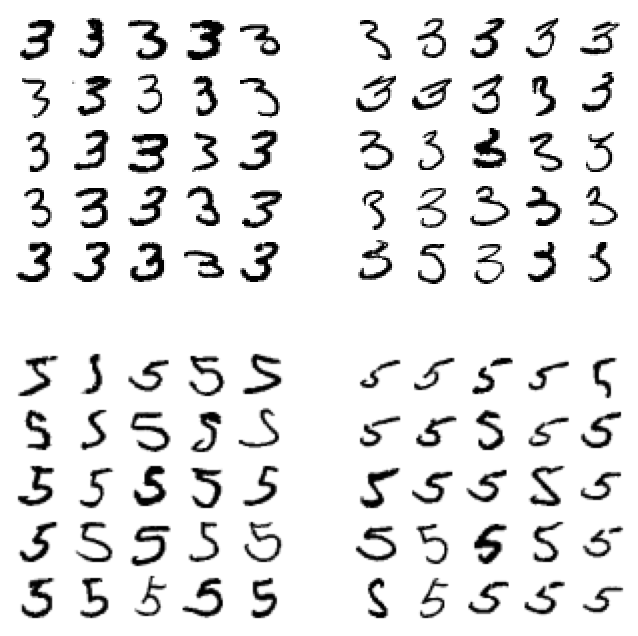

In [68]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

왼쪽의 5×5 블록 두 개는 3으로 분류된 이미지이고 오른쪽 5×5 블록 두 개는 5로 분류된 이미지입니다. 분류기가 잘못 분류한 숫자 중 일부는 정말 잘못 쓰여 있어서(왼쪽 아래 블록과 오른쪽 위 블록) 사람도 분류하기 어려울 것 같습니다(첫 번째 행, 두 번째 열의 5는 정말 갈겨 쓴 3처럼 보입니다). 그러나 대부분의 잘못 분류된 이미지는 확실히 에러인 것 같고 분류기가 실수한 이유를 이해하기 어렵습니다.\* 원인은 선형 모델인 `SGDClassifier`를 사용했기 때문입니다. 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산합니다. 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됩니다.

3과 5의 주요 차이는 왼쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치입니다. 숫자 3을 쓸 때 연결 부위가 조금 왼쪽으로 치우지면 분류기가 5로 분류하고, 또 반대도 마찬가지입니다. 다른 말로 하면 분류기는 이미지의 위치나 회전 방향에 매우 민감합니다. 3과 5의 에러를 줄이는 한가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것입니다. 이렇게하면 아마 다른 에러도 줄어들 것입니다.

---

\* 사람의 뇌가 환상적인 패턴 인식 시스템이라는 것을 기억하세요. 시각 시스템에서는 어떤 정보가 인식되기 전에 매우 많은 전처리를 수행합니다. 그래서 간단하게 보인다고 해도 진짜로 간단한 일이 아닐 수 있습니다.

## 3.6 다중 레이블 분류

지금까지는 각 샘플이 하나의 클래스에만 할당되었습니다. 하지만 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있습니다. 얼굴 인식 분류기를 한번 생각해봅시다. 같은 사진에 여러 사람이 등장한다면 어떻게 해야 할까요? 인식된 사람마다 하나씩 꼬리표$^{tag}$를 붙어야 합니다. 분류기가 앨리스, 밥, 찰리 세 얼굴을 인식하도록 훈련되었다고 가정해봅시다. 분류기가 앨리스와 찰리가 있는 사진을 본다면 \[1, 0, 1\]을 출력해야 할 것입니다(즉, \'앨리스 있음, 밥 없음, 찰리 있음\'). 이처럼 여러 개의 이진 꼬리표를 출력하는 분류 시스템을 <span style="color: #008000">다중 레이블 분류</span>$^{multilabel \ classificatoin}$ 시스템이라고 합니다.

여기서는 얼굴 인식 시스템을 만들려는 것이 아니므로 학습을 위해 조금 더 간단한 예를 살펴보겠습니다.

In [71]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

이 코드는 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 `y_multilabel` 배열을 만듭니다. 첫 번째 숫자가 큰 값(7, 8, 9)인지 나타내고 두 번째는 홀수인지 나타냅니다. 그다음 줄이 `KNeighborsClassifier` 인스턴스를 만들고 다중 타깃 배열을 사용하여 훈련시킵니다(`KNeighborsClassifier`는 다중 레이블 분류를 지원하지만 모든 분류기가 그런 것은 아닙니다\*). 이제 예측을 만들면 레이블이 두 개 출력됩니다.

---

\* 결정 트리, 랜덤 포레스트, `OneVsRestClassifier`에서도 다중 레이블 분류를 지원합니다.

In [72]:
knn_clf.predict([some_digit])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[False,  True]])

올바르게 분류되었습니다! 숫자 5는 크지 않고(**False**) 홀수(**True**)입니다.

다중 레이블 분류기를 평가하는 방법은 많습니다. 적절한 지표는 프로젝트에 따라 다릅니다. 예를 들어 각 레이블의 $F_1$ 점수를 구하고 (또는 앞서 언급한 어떤 이진 분류 지표를 사용하여) 간단하게 평균 점수를 계산합니다. 다음 코드는 모든 레이블에 대한 $F_1$ 점수의 평균을 계산합니다.

**경고**: 다음 셀은 실행하는데 매우 오래 걸립니다(하드웨어에 따라 몇 시간이 걸릴 수 있습니다).

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

실제로 아닐 수 있지만 이 코드는 모든 레이블의 가중치가 같다고 가정한 것입니다. 특히 앨리스 사진이 밥이나 찰리 사진보다 훨씬 많다면 앨리스 사진에 대한 분류기의 점수에 더 높은 가중치를 둘 것입니다. 간단한 방법은 레이블에 클래스의 <span style="color: #008000">지지도</span>$^{support}$(즉, 타깃 레이블에 속한 샘플 수)를 가중치로 주는 것입니다. 이렇게 하려면 이전 코드에서 `average="weighted"`로 설정하면 됩니다.\*

---

\* 사이킷런은 몇 가지 다른 평균 계산 방식과 다중 레이블 분류기 지표를 제공합니다. 자세한 내용은 공식 문서를 참고하세요. `average="micro"` 옵션은 모든 클래스의 FP, FN, TP 총합을 이용해 $F_1$ 점수를 계산합니다. `accuracy_score`, `precision_score`, `recall_score`, `classification_report` 함수 등이 다중 분류를 지원합니다.